# Content Based Movie Recommender System

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd 

# for nlp
import spacy

# visualisation libraries
import matplotlib.pyplot as plt 
# choose style
plt.style.use("seaborn-darkgrid")
import seaborn as sns 

# adjust pandas column width
pd.set_option('display.max_columns', 70)
pd.set_option('display.max_colwidth', 70)


In [2]:
# load the data
movies_df = pd.read_csv("data\movie_dataset.csv")
movies_df.head(2)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony society,en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentie...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver Stephen Lang Michelle...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'department': 'Editing...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trading company love of ...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life ...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckh...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stellan Skarsg\u00e5rd C...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'department': 'Camera', '...",Gore Verbinski


In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
# information
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

In [5]:
cols = ['index', 'title', 'genres', 'keywords', 'cast', 'director', 'tagline',  'vote_average', 'vote_count']

# new dataframe
df = movies_df.copy()
df = df[cols]
df.head(2)

,index,title,genres,keywords,cast,director,tagline,vote_average,vote_count
0,0,Avatar,Action Adventure Fantasy Science Fiction,culture clash future space war space colony society,Sam Worthington Zoe Saldana Sigourney Weaver Stephen Lang Michelle...,James Cameron,Enter the World of Pandora.,7.2,11800
1,1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action,ocean drug abuse exotic island east india trading company love of ...,Johnny Depp Orlando Bloom Keira Knightley Stellan Skarsg\u00e5rd C...,Gore Verbinski,"At the end of the world, the adventure begins.",6.9,4500


In [6]:
# determine the percentage of missing values for the object data type
missing_col_pct = (df.select_dtypes(include='object').isna().sum() / len(df)).sort_values(ascending=False).head(7)
missing_col_pct

tagline     0.175724
keywords    0.085780
cast        0.008953
director    0.006246
genres      0.005830
title       0.000000
dtype: float64

In [7]:
# missing columns
missing_cols = [*missing_col_pct.index]  # convert to list
missing_cols

['tagline', 'keywords', 'cast', 'director', 'genres', 'title']

In [8]:
df['vote_count'].describe()

count     4803.000000
mean       690.217989
std       1234.585891
min          0.000000
25%         54.000000
50%        235.000000
75%        737.000000
max      13752.000000
Name: vote_count, dtype: float64

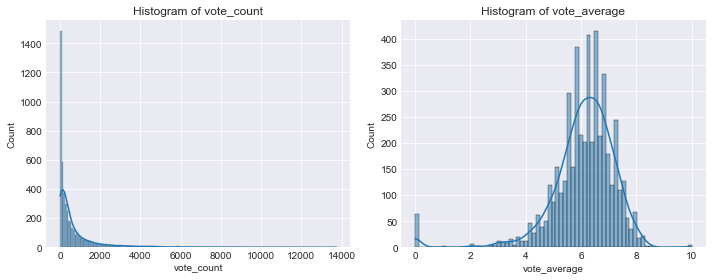

In [9]:
nrows, ncols = 1, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(nrows * 10, ncols * 2))
for idx, col in enumerate(['vote_count', 'vote_average']):
    ax = axs[idx]
    sns.histplot(data=df, x=col, ax=ax, kde=True)
    ax.set(title=f'Histogram of {col}')
    
fig.tight_layout()
plt.show()

**Comment:**
* The distribution of `vote_count` follows an exponential distribution while the distribution of `vote_average` is fairly normal and is negatively skewed.
* Since the distrbution of `vote_average` follows a normal distribution, it will be used as a feature for the recommender system.

In [10]:
# replace the values in the missing columns with '' i.e "nan" with ''
for col in missing_cols:
    df[col] = np.where(pd.isna(df[col]) == True, '', df[col])

In [11]:
# verifiy the operation that was performed above
df.loc[(df['tagline'] == ''), ['tagline', 'keywords']].head()

,tagline,keywords
10,,saving the world dc comics invulnerability sequel superhero
56,,sequel stranded hatred space opera
66,,age difference central and south america balloon animation floatin...
78,,based on novel snake wolf elephant tiger
128,,rome vatican based on novel symbolism christian


In [12]:
### Helper Functions

def important_features(df):
    # combine the important cols
    result = f"{df['title']} {df['genres']} {df['keywords']} {df['cast']} {df['director']}"

    return result


def clean_doc(my_str):
    """
    1. Convert my_str to doc (collection of spans).
    2. Remove the stopwords and punctuations from the token_list and store in filtered_tokens.
    3. Return filtered_tokens.
    """
    
    stop_words = nlp.Defaults.stop_words    # stopwords
    
   # convert to doc
    doc = nlp(my_str)
    
    # filtered tokens which have been converted to strings and remove the punctuations
    filtered_tokens = [str(token) for token in doc if token.is_stop == False and token.is_punct == False]
    
    return filtered_tokens


def get_movie_title(idx):
    """
    Returns the filtered movie index.
    """
    title = df.loc[df['index'] == idx, 'title'].values[0]
    
    return title


def get_index(title):
    """
    Returns the filtered movie title.
    """
    index = df.loc[df['title'] == title, 'index'].values[0]
    
    return index


def recommend_movies(user_movie_title, num=10):
    """
    num = number of movies to recommend
    It returns the recommended movie titles
    """

   
    index = get_index(user_movie_title)
    # get the cosine similarity of the movie using the movie index
    cosine_sim_of_movie = cosine_sim[index]

    cosine_sim_of_movie = [*enumerate(cosine_sim_of_movie)]   # list containing (idx, corr)

    # sort the cosine similarity of the movie by the correlation in descending order
    sorted_movies_corr = sorted(cosine_sim_of_movie, key=lambda movie_sim:movie_sim[1], reverse=True)[:num+1]

    # sort the cosine similarity of the movie by the vote_average in descending order
    sorted_movies_vote_avg = sorted(sorted_movies_corr, key=lambda movie_sim:df['vote_average'][movie_sim[0]], reverse=True)
    
    # List of the recommended movies
    recom_movies = [get_movie_title(idx) for c, (idx, corr) in enumerate(sorted_movies_vote_avg)]
    
    if user_movie_title in recom_movies:
        recom_movies.remove(user_movie_title)
    
    print(f"The {num} movies similar to '{user_movie_title}' are:")
    
    return recom_movies

In [13]:
# important columns to use for text preprocessing
imp_cols = ['title', 'genres', 'keywords', 'cast', 'director', 'tagline']

# add a new feature
df['imp_features'] = df.apply(important_features, axis='columns')

df.head(2)

,index,title,genres,keywords,cast,director,tagline,vote_average,vote_count,imp_features
0,0,Avatar,Action Adventure Fantasy Science Fiction,culture clash future space war space colony society,Sam Worthington Zoe Saldana Sigourney Weaver Stephen Lang Michelle...,James Cameron,Enter the World of Pandora.,7.2,11800,Avatar Action Adventure Fantasy Science Fiction culture clash futu...
1,1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action,ocean drug abuse exotic island east india trading company love of ...,Johnny Depp Orlando Bloom Keira Knightley Stellan Skarsg\u00e5rd C...,Gore Verbinski,"At the end of the world, the adventure begins.",6.9,4500,Pirates of the Caribbean: At World's End Adventure Fantasy Action ...


### Preprocess the text features

In [14]:
# cal the 'bag of words' and 'TFIDF' of the 'imp_features'
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidf_vec = TfidfVectorizer(analyzer=clean_doc)
imp_feats_vec = tfidf_vec.fit_transform(df['imp_features'])

In [16]:
# calculate the cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
# Cal the cosine similarity of the 'important_features'
cosine_sim = cosine_similarity(imp_feats_vec)

# Recommend a movie for a user who likes...
user_movie_title = 'The Dark Knight Rises'

# get the cosine similarity of the movie using the movie index
cosine_sim_of_movie = cosine_sim[get_index(user_movie_title)]

cosine_sim_of_movie = [*enumerate(cosine_sim_of_movie)]   # list containing (idx, corr)

# sort the cosine similarity of the movie by the correlation in descending order
sorted_movies_corr = sorted(cosine_sim_of_movie, key=lambda movie_sim:movie_sim[1], reverse=True)[:10]

# sort the cosine similarity of the movie by the vote_average in descending order
sorted_movies_vote_avg = sorted(sorted_movies_corr, key=lambda movie_sim:df['vote_average'][movie_sim[0]], reverse=True)

In [18]:
for c, (idx, corr) in enumerate(sorted_movies_vote_avg):  # c is the counter
    if c < 10:   
        # Get the movie title
        print(get_movie_title(idx))

The Dark Knight
Interstellar
The Prestige
Batman: The Dark Knight Returns, Part 2
The Dark Knight Rises
Batman Begins
Batman
Superman
Batman Returns
Batman & Robin


In [19]:
recommend_movies('The Book of Eli')

The 10 movies similar to 'The Book of Eli' are:


['Terminator 2: Judgment Day',
 'Dawn of the Planet of the Apes',
 'Mad Max: Fury Road',
 'The Great Debaters',
 'Antwone Fisher',
 '9',
 'The Hunger Games: Mockingjay - Part 1',
 'Mad Max',
 'Priest',
 'Max Payne']